In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
EPSILON = 1e-8 # np.finfo(float).eps  # machine precision

In [3]:
def plane_intersection(ray, plane):
    ''' Find the intersection point between a ray and a plane
            ray: tuple (A, u) starting point and direction
            plane: tuple (P, n, ux) origin, normal direction and in-plane x-axis
            
        Returns:
            coordinates of the intersection point in the 3D ref. frame
            coordinates of the intersection point in the plane ref. frame (u, v)
    '''
    A, u = ray
    P, n, plane_x = plane
    
    A, P = np.asarray(A), np.asarray(P)
    u, n, plane_x = np.asarray(u), np.asarray(n), np.asarray(plane_x)
    
    u_dot_n = np.inner(u, n)
    AP_dot_n = np.inner(P - A, n)
    
    if u_dot_n >= -EPSILON and AP_dot_n >= -EPSILON:    
        # print('do not colide')
        return None, None
    else:
        t = AP_dot_n / u_dot_n  # time of collision
        B = A + u*t   # collision point
        
        plane_y = np.cross(n, plane_x)
        proj_x = np.inner(plane_x, B-P)
        proj_y = np.inner(plane_y, B-P)
        return B, (proj_x, proj_y)

# test
A = (1.2, 0, 0)
u = (-1, 0, 0)
ray = (A, u)

P = (0, 0, 0)
n = (1, 1, 4)
plane_x = (-1, 1, 0)
plane = (P, n, plane_x)

assert np.allclose(plane_intersection(ray, plane)[0], [0., 0., 0.])

In [4]:
def rodrigues_rotation(vector, axis, theta):
    ''' Rotate the vector arround the direction 
        of an angle theta (radian)
        using the Rodrigues formula
    '''
    vector, axis = np.asarray(vector), np.asarray(axis)

    axis = axis/np.linalg.norm(axis)

    rotated = vector*np.cos(theta) + np.cross(axis, vector)*np.sin(theta)\
                + axis*np.inner(axis, vector)*(1-np.cos(theta))
    return rotated

# test
theta = np.pi/4
axis = (0, 0, 1)
vector = (1, 0, 0)

rotated = rodrigues_rotation(vector, axis, theta)
assert np.allclose(rotated, [np.sqrt(2)/2, np.sqrt(2)/2, 0.])

In [5]:
# Diffraction by a powder
def diffraction_cone(u_incident, deuxtheta):
    ''' Generate diffraction direction by a powder
        i.e. a cone of semi-angle deuxtheta (radian)  and axis u_incident
        
        return a function:
            - the input is the out-of-plane diffraction angle alpha
            - output the diffracted direction vector
    '''
    y_axis = (0, 1, 0)

    generatrice = rodrigues_rotation(u, y_axis, deuxtheta)

    u_diff = lambda alpha: rodrigues_rotation(generatrice, u, alpha)
    return u_diff

# test
u_incident = (-1, 0, 0)
deuxtheta = np.pi/4
u_diff = diffraction_cone(u_incident, deuxtheta)

assert np.allclose(u_diff(0), [-np.sqrt(2)/2, 0, np.sqrt(2)/2])
assert np.allclose(u_diff(np.pi), [-np.sqrt(2)/2, 0, -np.sqrt(2)/2])

In [6]:
u_diff(np.pi)

array([-7.07106781e-01,  8.65956056e-17, -7.07106781e-01])

In [7]:
def diffract(incident_direction, B, detector_plane, deuxtheta, alpha):
    
    u_diff = diffraction_cone(incident_direction, deuxtheta)
    uB = u_diff(alpha)
    diffracted_ray = (B, uB)
    C, uv = plane_intersection(diffracted_ray, detector_plane)
    return uv

In [8]:
# Define detector
deuxtheta = np.pi/4
rayon_gonio = 420 # mm
detector_position  = (-rayon_gonio*np.cos(deuxtheta),
                      0,
                      +rayon_gonio*np.sin(deuxtheta))
detector_normal = (+np.cos(deuxtheta),
                   0,
                   -np.sin(deuxtheta))
detector_x_axis = (+np.sin(deuxtheta),
                    0,
                   +np.cos(deuxtheta))

detector_plane = (detector_position, detector_normal, detector_x_axis)

In [9]:
import itertools as it

In [10]:
alpha_range = np.pi/40
beam_height = 1.2 # mm
beam_width = 0.5 # mm

alpha_span = np.linspace(-alpha_range/2, +alpha_range/2, 11)
Ay_span = np.linspace(-beam_height/2, +beam_height/2, 11)
Az_span = np.linspace(-beam_width/2, +beam_width/2, 11)

points = []
for Az, Ay, alpha in it.product(Az_span, Ay_span, alpha_span):
    u_incident = (-1, 0, 0)
    B = (0, Ay, Az)
    uv = diffract(u_incident, B, detector_plane, deuxtheta, alpha)
    points.append( uv )

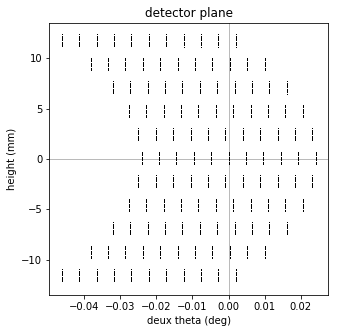

In [11]:
u, v = list(zip(*points))
u_deuxtheta = np.array(u)/rayon_gonio*180/np.pi
plt.figure(figsize=(5, 5))
plt.axvline(x=0, color='black', linewidth=1, alpha=0.27);
plt.axhline(y=0, color='black', linewidth=1, alpha=0.27);
plt.plot(u_deuxtheta, v, ',k');
#plt.axis('square');
plt.xlabel('deux theta (deg)');
plt.ylabel('height (mm)');
plt.title('detector plane');

In [12]:
detector_normal

(0.7071067811865476, 0, -0.7071067811865475)

In [13]:
detector_position

(-296.98484809834997, 0, 296.9848480983499)

(array([0., 0., 0.]), (0.0, 0.0))